<a href="https://colab.research.google.com/github/madhurlak0810/SEC-edgar/blob/test_inesh/Project_602_Checkpoint_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Checkpoint 2***

**Data Processing and Data Cleaning**
We have imported the data from sec.gov api endpoint, the end point provides information regarding company tickers.
Inoformation of companies with following information:
1. listed in nasdaq with in the technology sector
2. an active IPO year having a market cap > 1 Mil
3. Country is USA and volume of shares greater than 1000
has been gathered from nasdaq.

Finally a companies_considered dataframe is filtered and created.

CIK or unique identifier from sec edgar is used to lookup company information as gathered from nasdaq.

After matching the company information with the cik lookup, we get further information regarding interested companies using another api endpoint 'companyfacts'

The result of this api contains different parameters regarding the company and with filing information about when they were filed.

Data_list contians the list of most relevant parameters which are present across multiple companies chosen for analysis.

Finally, all relevant information is merged with parameters transposed to create a dataframe required for further analysis.

**Basic data exploration and summary statistics**

Pandas describe function is used to get a summary information about the created dataframe and missing value information is dispalyed across all present columns

*Statistical methods applied*

1. Correlation Matrix
- We use this to present a correlation between all the parameters we are interested in.
2. Hypothesis Testing
- Null Hypothesis: Increased share-based compensation is associated with higher growth in stockholders' equity
- Share-Based Compensation and Equity Growth Hypothesis
3. Regression Analysis
- This explores the relationship between Allocated Share-Based Compensation Expense (treated as a proxy for R&D expenses) and Stockholders' Equity Growth. The primary goal is to determine how changes might impact stockholders' equity over time.
4. Anova Testing
- Analysis of Variance (ANOVA) is conducted to test statistical significance between Allocated Share-Based Compensation Expense (R&D) and Stockholders' Equity Growth. We aim to determine if the means of these two metrics differ.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Define the URL for the SEC EDGAR search page
url = "https://www.sec.gov/files/company_tickers_exchange.json"

headers = {
   "User-Agent": "your.email@email.com"
}
# Fetch the HTML content of the search page
response = requests.get(url,headers=headers)
html_content = response.content

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, 'html.parser')

In [ ]:
# Parse the JSON content from the BeautifulSoup object
json_data = json.loads(soup.text)

# Convert the JSON data into a pandas DataFrame
df_cik_lookup = pd.DataFrame(json_data['data'], columns=json_data['fields'])


# df_cik_lookup['cik']=df_cik_lookup['cik'].astype(str).zfill(10)
# df_cik_lookup

In [ ]:
df_cik_lookup.head()

,cik,name,ticker,exchange
0,1045810,NVIDIA CORP,NVDA,Nasdaq
1,320193,Apple Inc.,AAPL,Nasdaq
2,789019,MICROSOFT CORP,MSFT,Nasdaq
3,1018724,AMAZON COM INC,AMZN,Nasdaq
4,1652044,Alphabet Inc.,GOOGL,Nasdaq


Get a list of companies listed in NASDAQ, filter for Technology companies with an active IPO year, market cap > 1 Mil, Country is USA and volume of shares is greater than 1000

In [ ]:

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('nasdaq_screener_1729013554057.csv')

# Convert the 'IPO Year' column to integer format, handling potential errors
df['IPO Year'] = pd.to_numeric(df['IPO Year'], errors='coerce').astype('Int64')


# Filter the DataFrame based on the specified criteria
filtered_df = df[(df['Country'] == 'United States') &
                 (df['Sector'] == 'Technology') &
                 (df['IPO Year'].notna()) &
                 (df['Market Cap'] > 1000000) &
                 (df['Volume'] >= 1000)]

filtered_df = filtered_df[~filtered_df['Name'].str.contains('warrant', case=False)]

# Sort the DataFrame in descending order based on 'Market Cap' and select the top 50
filtered_df = filtered_df.sort_values('Market Cap', ascending=False).head(50)


columns_to_remove = ['Last Sale', 'Net Change', 'Unnamed: 8', '% Change', 'Volume', 'Sector']

# Remove the specified columns from the DataFrame
companies_considered = filtered_df.drop(columns=columns_to_remove, errors='ignore')

# assign a new index starting from 1
companies_considered.index = np.arange(1, len(companies_considered) + 1)

companies_considered.head()

,Symbol,Name,Market Cap,Country,IPO Year,Industry
1,AAPL,Apple Inc. Common Stock,3.563394e+12,United States,1980,Computer Manufacturing
2,NVDA,NVIDIA Corporation Common Stock,3.220298e+12,United States,1999,Semiconductors
3,MSFT,Microsoft Corporation Common Stock,3.105449e+12,United States,1986,Computer Software: Prepackaged Software
4,GOOG,Alphabet Inc. Class C Capital Stock,2.062048e+12,United States,2004,Computer Software: Programming Data Processing
5,GOOGL,Alphabet Inc. Class A Common Stock,2.044937e+12,United States,2004,Computer Software: Programming Data Processing


In [ ]:

# Perform an inner join on 'ticker' and 'Symbol' columns
merged_df = pd.merge(df_cik_lookup, companies_considered, left_on='ticker', right_on='Symbol', how='inner')

# Print the merged DataFrame
print(merged_df.columns)

Index(['cik', 'name', 'ticker', 'exchange', 'Symbol', 'Name', 'Market Cap',
       'Country', 'IPO Year', 'Industry'],
      dtype='object')


In [ ]:
def make_edgar_request(url):
    """
    Make a request to EDGAR (Electronic Data Gathering, Analysis and Retrieval)
    :param url: request URL
    :return: response
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36",
        "Accept-Encoding": "gzip, deflate, br",
    }
    return requests.get(url, headers=headers)

In [ ]:
def get_company_data(cik):
  """Fetches and processes data for a given CIK."""

  url = f"https://data.sec.gov/api/xbrl/companyfacts/CIK{str(cik).zfill(10)}.json"
  header = {
    "User-Agent": "your.email@email.com"  # Replace with your actual email
  }

  response = requests.get(url, headers=header)

  if response.status_code == 200:
    data = response.json()

    us_gaap_data = data.get("facts", {}).get("us-gaap", {})
    table_data = []

    for concept, values in us_gaap_data.items():
      for value in values.get("units", {}).get("USD", []):
        if "val" in value:
          table_data.append([concept, value.get("val"), value.get("fy"), value.get("fp")])

    df = pd.DataFrame(table_data, columns=["Concept", "Value", "Fiscal Year", "Fiscal Period"])
    entity_name = data.get("entityName", "Unknown")  # Get the entity name
    df["entityName"] = entity_name  # Add entity name as a column
    df["cik"] = cik  # Add CIK as a column
    return df
  else:
    print(f"Error: {response.status_code}")
    return None

In [ ]:
data_list = [
    "AccountsPayableCurrent",
    "AllocatedShareBasedCompensationExpense",
    "Assets",
    "AssetsCurrent",
    "CashAndCashEquivalentsAtCarryingValue",
    "ComprehensiveIncomeNetOfTax",
    "CurrentFederalTaxExpenseBenefit",
    "CurrentStateAndLocalTaxExpenseBenefit",
    "DeferredFederalIncomeTaxExpenseBenefit",
    "IncomeTaxExpenseBenefit",
    "LesseeOperatingLeaseLiabilityPaymentsDueNextTwelveMonths",
    "LiabilitiesAndStockholdersEquity",
    "LiabilitiesCurrent",
    "NetIncomeLoss",
    "OperatingIncomeLoss",
    "OperatingLeasePayments",
    "PropertyPlantAndEquipmentGross",
    "PropertyPlantAndEquipmentNet",
    "ShareBasedCompensation",
    "StockholdersEquity",
    "UnrecognizedTaxBenefits"
]

In [ ]:


# Get a list of CIKs from the merged DataFrame
CIKs_to_process = merged_df["cik"].tolist()

# Initialize an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

for CIK in CIKs_to_process:
  company_df = get_company_data(CIK)
  if company_df is not None:
    combined_df = pd.concat([combined_df, company_df], ignore_index=True)

combined_df.head()

<ipython-input-11-ad99911b72ff>:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([combined_df, company_df], ignore_index=True)


,Concept,Value,Fiscal Year,Fiscal Period,entityName,cik
0,AcceleratedShareRepurchaseProgramAdjustment,9000000.0,2016.0,Q2,NVIDIA CORP,1045810
1,AcceleratedShareRepurchaseProgramAdjustment,9000000.0,2016.0,Q3,NVIDIA CORP,1045810
2,AcceleratedShareRepurchasesSettlementPaymentOr...,750000000.0,2013.0,Q2,NVIDIA CORP,1045810
3,AcceleratedShareRepurchasesSettlementPaymentOr...,750000000.0,2013.0,Q1,NVIDIA CORP,1045810
4,AcceleratedShareRepurchasesSettlementPaymentOr...,750000000.0,2013.0,Q3,NVIDIA CORP,1045810


In [ ]:
df_concepts = pd.DataFrame(data_list, columns=['Concept'])

In [ ]:
# Perform a join on 'concepts' and 'Concept' columns
joined_df = pd.merge(df_concepts, combined_df, left_on='Concept', right_on='Concept', how='inner')

joined_df.head()

,Concept,Value,Fiscal Year,Fiscal Period,entityName,cik
0,AccountsPayableCurrent,218864000.0,2009.0,Q2,NVIDIA CORP,1045810
1,AccountsPayableCurrent,218864000.0,2009.0,Q3,NVIDIA CORP,1045810
2,AccountsPayableCurrent,218864000.0,2010.0,FY,NVIDIA CORP,1045810
3,AccountsPayableCurrent,275978000.0,2009.0,Q2,NVIDIA CORP,1045810
4,AccountsPayableCurrent,321530000.0,2009.0,Q3,NVIDIA CORP,1045810


In [ ]:
# Filter for Fiscal Period = FY
filtered_joined_df = joined_df[joined_df['Fiscal Period'] == 'FY']

# Make the data unique based on concept, fiscal year, and entityName
unique_df = filtered_joined_df.drop_duplicates(subset=['Concept', 'Fiscal Year', 'entityName'])

unique_df.head()

,Concept,Value,Fiscal Year,Fiscal Period,entityName,cik
2,AccountsPayableCurrent,218864000.0,2010.0,FY,NVIDIA CORP,1045810
17,AccountsPayableCurrent,286138000.0,2011.0,FY,NVIDIA CORP,1045810
25,AccountsPayableCurrent,335072000.0,2012.0,FY,NVIDIA CORP,1045810
33,AccountsPayableCurrent,356428000.0,2013.0,FY,NVIDIA CORP,1045810
41,AccountsPayableCurrent,324391000.0,2014.0,FY,NVIDIA CORP,1045810


In [ ]:
# Transposing unique_df
transposed_df = unique_df.pivot_table(index=['cik', 'entityName', 'Fiscal Year'], columns='Concept', values='Value', aggfunc='first')

transposed_df = transposed_df.reset_index()

transposed_df.head()

Concept,cik,entityName,Fiscal Year,AccountsPayableCurrent,AllocatedShareBasedCompensationExpense,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,ComprehensiveIncomeNetOfTax,CurrentFederalTaxExpenseBenefit,...,LiabilitiesAndStockholdersEquity,LiabilitiesCurrent,NetIncomeLoss,OperatingIncomeLoss,OperatingLeasePayments,PropertyPlantAndEquipmentGross,PropertyPlantAndEquipmentNet,ShareBasedCompensation,StockholdersEquity,UnrecognizedTaxBenefits
0,6951,APPLIED MATERIALS INC /DE,2009.0,NaN,NaN,1.100632e+10,6.664157e+09,8.614630e+08,1.738268e+09,NaN,...,1.100632e+10,2.945552e+09,1.710196e+09,2.371506e+09,NaN,2.831952e+09,1.094200e+09,161196000.0,7.548958e+09,NaN
1,6951,APPLIED MATERIALS INC /DE,2010.0,477148000.0,178943000.0,1.100632e+10,5.688947e+09,1.202722e+09,9.228230e+08,248308000.0,...,9.574243e+09,1.939457e+09,9.607460e+08,1.355431e+09,NaN,2.906957e+09,1.090433e+09,178943000.0,7.821409e+09,363400000.0
2,6951,APPLIED MATERIALS INC /DE,2011.0,658000000.0,147000000.0,9.574000e+09,6.765000e+09,1.411000e+09,-2.800000e+08,-197000000.0,...,1.094300e+10,2.888000e+09,-3.050000e+08,-3.940000e+08,NaN,2.869000e+09,9.630000e+08,147000000.0,7.549000e+09,325000000.0
3,6951,APPLIED MATERIALS INC /DE,2012.0,484000000.0,126000000.0,1.386100e+10,1.035500e+10,1.576000e+09,9.420000e+08,463000000.0,...,1.386100e+10,2.794000e+09,9.380000e+08,1.384000e+09,NaN,2.738000e+09,8.660000e+08,126000000.0,7.094000e+09,328000000.0
4,6951,APPLIED MATERIALS INC /DE,2013.0,396000000.0,146000000.0,1.210200e+10,5.102000e+09,1.858000e+09,1.930000e+09,290000000.0,...,1.210200e+10,2.265000e+09,1.926000e+09,2.398000e+09,NaN,2.917000e+09,9.100000e+08,146000000.0,7.536000e+09,59000000.0


Descriptive Statistics: Use pandas to get a summary of the dataset, such as mean, median, standard deviation, and range:

In [ ]:
# Get descriptive statistics
descriptive_stats = transposed_df.describe()

print(descriptive_stats)

Concept           cik  Fiscal Year  AccountsPayableCurrent  \
count    5.000000e+02   500.000000            4.590000e+02   
mean     1.093908e+06  2017.648000            2.298792e+09   
std      4.468780e+05     4.106803            7.781298e+09   
min      6.951000e+03  2009.000000            1.276000e+03   
25%      8.270540e+05  2014.000000            3.909450e+07   
50%      1.108524e+06  2018.000000            1.846000e+08   
75%      1.404655e+06  2021.000000            6.369000e+08   
max      1.835632e+06  2024.000000            6.411500e+10   

Concept  AllocatedShareBasedCompensationExpense        Assets  AssetsCurrent  \
count                              3.720000e+02  5.000000e+02   5.000000e+02   
mean                               8.033659e+08  3.456848e+10   1.630303e+10   
std                                1.947035e+09  7.245387e+10   3.493051e+10   
min                               -1.110000e+08  2.500000e+04   2.500000e+04   
25%                                3.8232

Check for Missing Values: To find any missing values:

In [ ]:
# Check for missing values
missing_values = transposed_df.isnull().sum()

print(missing_values)

Concept
cik                                                           0
entityName                                                    0
Fiscal Year                                                   0
AccountsPayableCurrent                                       41
AllocatedShareBasedCompensationExpense                      128
Assets                                                        0
AssetsCurrent                                                 0
CashAndCashEquivalentsAtCarryingValue                        10
ComprehensiveIncomeNetOfTax                                  47
CurrentFederalTaxExpenseBenefit                              54
CurrentStateAndLocalTaxExpenseBenefit                        41
DeferredFederalIncomeTaxExpenseBenefit                       60
IncomeTaxExpenseBenefit                                       4
LesseeOperatingLeaseLiabilityPaymentsDueNextTwelveMonths    283
LiabilitiesAndStockholdersEquity                              0
LiabilitiesCurrent              

Visualize Data Distribution:

Compute Correlation Matrix: To see how the features correlate with one another, compute the correlation matrix using pandas:

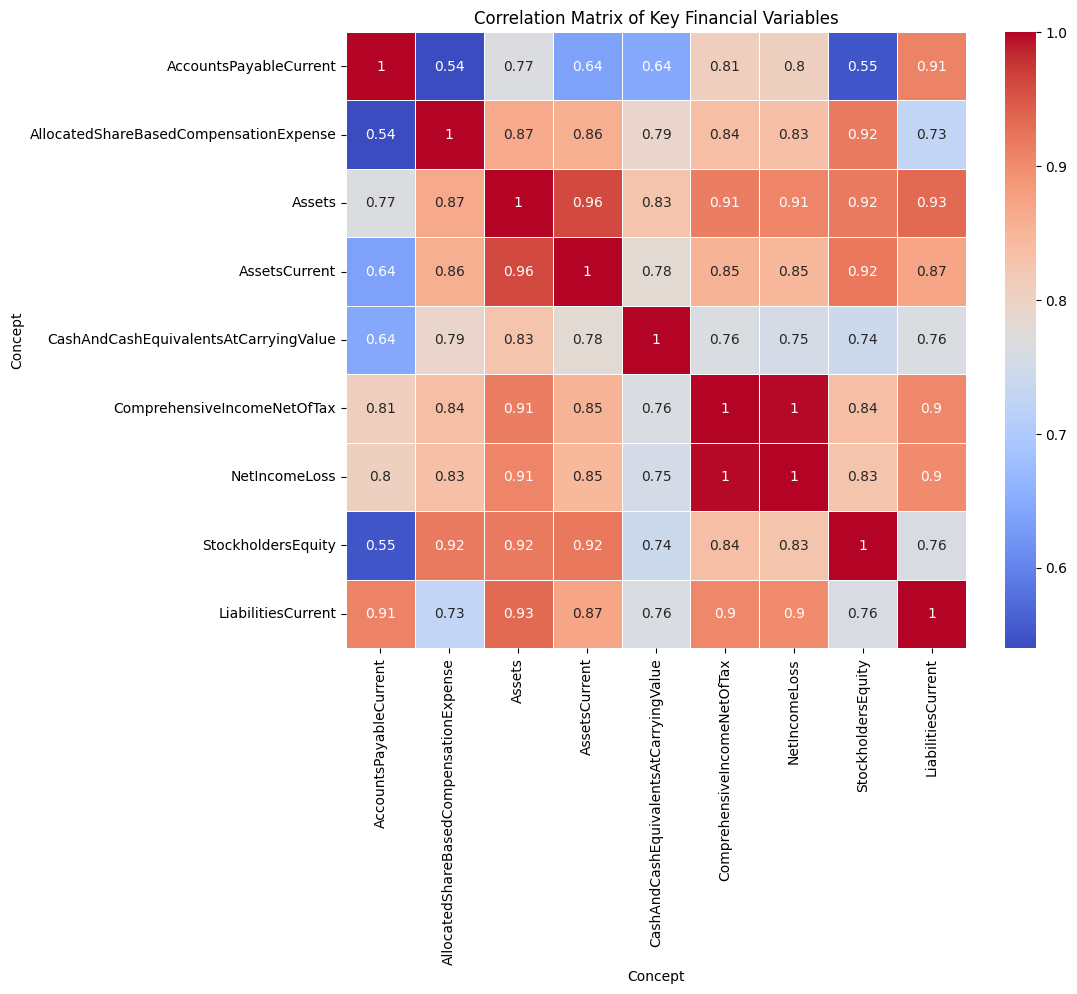

In [ ]:
# Parameters we are interested in
columns = [
    'AccountsPayableCurrent', 'AllocatedShareBasedCompensationExpense', 'Assets', 'AssetsCurrent',
    'CashAndCashEquivalentsAtCarryingValue', 'ComprehensiveIncomeNetOfTax', 'NetIncomeLoss',
    'StockholdersEquity', 'LiabilitiesCurrent'
]

# correlation matrix
correlation_matrix = transposed_df[columns].corr()

import seaborn as sns
import matplotlib.pyplot as plt

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Key Financial Variables')
plt.show()

Hypothesis Testing

In [ ]:
# Filter for relevant concepts
rd_expense_df = unique_df[unique_df['Concept'] == 'AllocatedShareBasedCompensationExpense']
growth_df = unique_df[unique_df['Concept'] == 'StockholdersEquity']

merged_df = pd.merge(rd_expense_df, growth_df, on=['Fiscal Year', 'Fiscal Period', 'entityName', 'cik'], suffixes=('_R&D', '_Growth'))

from scipy.stats import pearsonr

# R&D expense and growth values
rd_expense = merged_df['Value_R&D']
growth = merged_df['Value_Growth']

# Pearson correlation test
correlation, p_value = pearsonr(rd_expense, growth)

print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant correlation between R&D investment and growth.")
else:
    print("Fail to reject the null hypothesis: No significant correlation between R&D investment and growth.")

Pearson Correlation Coefficient: 0.918418704280406
P-value: 7.69760676628573e-146
Reject the null hypothesis: There is a significant correlation between R&D investment and growth.


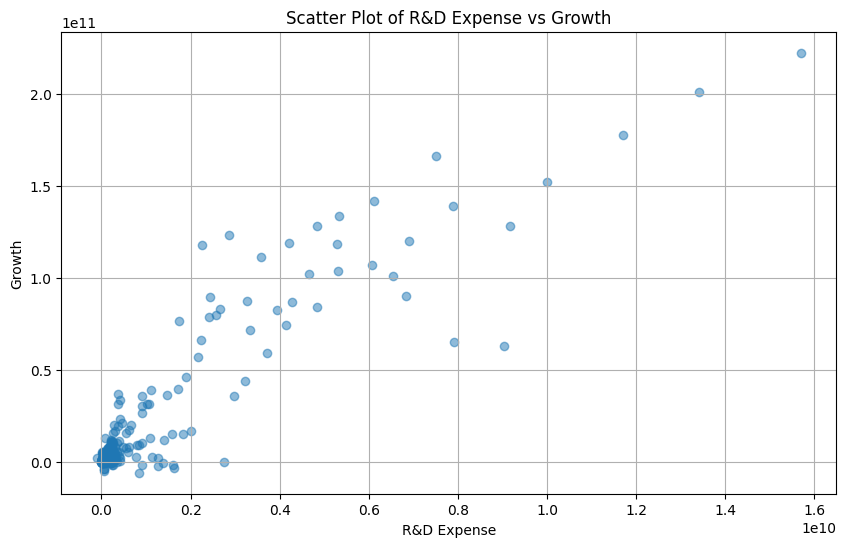

In [ ]:
# scatter plot for R&D expense and growth
plt.figure(figsize=(10, 6))
plt.scatter(rd_expense, growth, alpha=0.5)
plt.title('Scatter Plot of R&D Expense vs Growth')
plt.xlabel('R&D Expense')
plt.ylabel('Growth')
plt.grid(True)
plt.show()

Regression Analysis of Share Based Compensation and Stock Holder Equity

In [ ]:
rd_expense_df = unique_df[unique_df['Concept'] == 'AllocatedShareBasedCompensationExpense']
growth_df = unique_df[unique_df['Concept'] == 'StockholdersEquity']

# data merging
merged_df = pd.merge(rd_expense_df, growth_df, on=['Fiscal Year', 'Fiscal Period', 'entityName', 'cik'], suffixes=('_R&D', '_Growth'))

import statsmodels.api as sm

X = merged_df['Value_R&D']
y = merged_df['Value_Growth']
X = sm.add_constant(X)  # Add a constant term for the intercept

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Value_Growth   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     1924.
Date:                Sat, 07 Dec 2024   Prob (F-statistic):          7.70e-146
Time:                        19:43:40   Log-Likelihood:                -8890.9
No. Observations:                 359   AIC:                         1.779e+04
Df Residuals:                     357   BIC:                         1.779e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.342e+09   7.86e+08      2.981      0.0

Anova testing

In [ ]:
from statsmodels.formula.api import ols
import pandas as pd

import statsmodels.api as sm

anova_df = merged_df[['Value_R&D', 'Value_Growth']]

anova_df_melt = pd.melt(anova_df.reset_index(), id_vars=['index'], value_vars=['Value_R&D', 'Value_Growth'])
anova_df_melt.columns = ['index', 'variable', 'value']

# Perform ANOVA
model = ols('value ~ C(variable)', data=anova_df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                   sum_sq     df          F        PR(>F)
C(variable)  3.700078e+22    1.0  60.599521  2.452532e-14
Residual     4.371744e+23  716.0        NaN           NaN


In [ ]:
# Result interpretation
if anova_table.loc['C(variable)', 'PR(>F)'] < 0.05:
    print("Reject the null hypothesis: There are significant differences between groups.")
else:
    print("Fail to reject the null hypothesis: No significant differences between groups.")

Reject the null hypothesis: There are significant differences between groups.


In [ ]:
merged_df.head()

,Concept_R&D,Value_R&D,Fiscal Year,Fiscal Period,entityName,cik,Concept_Growth,Value_Growth
0,AllocatedShareBasedCompensationExpense,104588000.0,2011.0,FY,NVIDIA CORP,1045810,StockholdersEquity,2.394652e+09
1,AllocatedShareBasedCompensationExpense,101996000.0,2012.0,FY,NVIDIA CORP,1045810,StockholdersEquity,2.665140e+09
2,AllocatedShareBasedCompensationExpense,136498000.0,2013.0,FY,NVIDIA CORP,1045810,StockholdersEquity,3.181462e+09
3,AllocatedShareBasedCompensationExpense,137101000.0,2014.0,FY,NVIDIA CORP,1045810,StockholdersEquity,4.145724e+09
4,AllocatedShareBasedCompensationExpense,136000000.0,2015.0,FY,NVIDIA CORP,1045810,StockholdersEquity,4.827000e+09


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Value_R&D'].plot(kind='hist', bins=20, title='Value_R&D')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Fiscal Year'].plot(kind='hist', bins=20, title='Fiscal Year')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Value_Growth'].plot(kind='hist', bins=20, title='Value_Growth')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='Value_R&D', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Value_R&D', y='Fiscal Year', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Fiscal Year', y='Value_Growth', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Value_R&D']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Value_R&D')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Fiscal Year']
  ys = series['Value_R&D']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Fiscal Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Fiscal Year')
_ = plt.ylabel('Value_R&D')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Fiscal Year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Fiscal Year'}, axis=1)
              .sort_values('Fiscal Year', ascending=True))
  xs = counted['Fiscal Year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Fiscal Year', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Fiscal Year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Value_R&D'].plot(kind='line', figsize=(8, 4), title='Value_R&D')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Fiscal Year'].plot(kind='line', figsize=(8, 4), title='Fiscal Year')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Value_Growth'].plot(kind='line', figsize=(8, 4), title='Value_Growth')
plt.gca().spines[['top', 'right']].set_visible(False)

Mean Squared Error: 2.7633244566315323e+20
R-squared: 0.8325069372818636


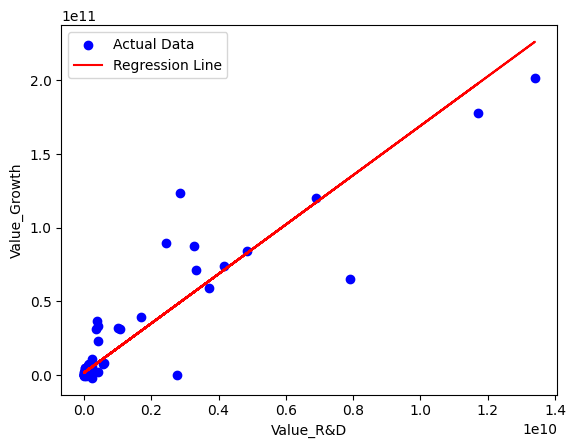

In [ ]:
X = merged_df[['Value_R&D']]
y = merged_df['Value_Growth']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.scatter(x_test,y_test,color = 'blue',label='Actual Data')
plt.plot(x_test,y_pred, color = 'red',label='Regression Line')
plt.xlabel('Value_R&D')
plt.ylabel('Value_Growth')
plt.legend()
plt.show()

In [ ]:
def download_document(url, cik, form_type, filing_date):
    response = make_edgar_request(url)
    r = response.text
    doc = {"html": r, "cik": cik, "form_type": form_type, "filing_date": filing_date, "updated_at": updated_at, "_id": url}
    try:
        mongodb.insert_document("documents", doc)
    except DocumentTooLarge:
        # DocumenTooLarge is raised by mongodb when uploading files larger than 16MB
        # To avoid this it is better to save this kind of files in a separate storate like S3 and retriving them when needed.
        # Another options could be using mongofiles: https://www.mongodb.com/docs/database-tools/mongofiles/#mongodb-binary-bin.mongofiles
        # for management of large files saved in mongo db.
        print("Document too Large (over 16MB)", url)
    pass

In [ ]:
def make_edgar_request(url):
    """
    Make a request to EDGAR (Electronic Data Gathering, Analysis and Retrieval)
    :param url:
    :return: response
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36",
        "Accept-Encoding": "gzip, deflate, br",
    }
    return requests.get(url, headers=headers)

In [ ]:
def download_submissions_documents(cik, forms_to_download=("10-Q", "10-K", "8-K"), years=5):
    """
    Download all documents for submissions forms 'forms_to_download' for the past 'max_history' years.
    Insert them on mongodb.
    :param cik: company cik
    :param forms_to_download: a tuple containing the form types to download
    :param years: the max number of years to download
    :return:
    """
    try:
        submissions = mongodb.get_document("submissions", cik)
    except StopIteration:
        print(f"submissions file not found in mongodb for {cik}")
        return
    cik_no_trailing = submissions["cik"]
    filings = submissions["filings"]["recent"]
    for i in range(len(filings["filingDate"])):
        filing_date = filings['filingDate'][i]
        difference_in_years = relativedelta(datetime.date.today(),
                                            datetime.datetime.strptime(filing_date, "%Y-%m-%d")).years
        # as the document are ordered cronologically when we reach the max history we can return
        if difference_in_years > years:
            return
        form_type = filings['form'][i]
        if form_type not in forms_to_download:
            continue
        accession_no_symbols = filings["accessionNumber"][i].replace("-","")
        primary_document = filings["primaryDocument"][i]
        url = f"https://www.sec.gov/Archives/edgar/data/{cik_no_trailing}/{accession_no_symbols}/{primary_document}"
        # if we already have the document, we don't download it again
        if mongodb.check_document_exists("documents", url):
            continue
        print(f"{filing_date} ({form_type}): {url}")
        download_document(url, cik, form_type, filing_date)
        # insert a quick sleep to avoid reaching edgar rate limit
        time.sleep(0.2)